# 磁気中性線の検出

## ドライブのマウント

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## ライブラリのインポート

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

## 関数の定義

In [ ]:
# 条件以外のオブジェクトを削除
def remove_objects(img, lower_size=None, upper_size=None):
    # find all objects
    nlabels, labels, stats, centroids = cv2.connectedComponentsWithStats(img)

    sizes = stats[1:, -1]
    _img = np.zeros((labels.shape))

    # process all objects, label=0 is background, objects are started from 1
    for i in range(1, nlabels):

        # remove small objects
        if (lower_size is not None) and (upper_size is not None):
            if lower_size < sizes[i - 1] and sizes[i - 1] < upper_size:
                _img[labels == i] = 255

        elif (lower_size is not None) and (upper_size is None):
            if lower_size < sizes[i - 1]:
                _img[labels == i] = 255

        elif (lower_size is None) and (upper_size is not None):
            if sizes[i - 1] < upper_size:
                _img[labels == i] = 255

    return _img, stats

## 画像の読み込み

In [ ]:
rfile = "/content/drive/MyDrive/Colab Notebooks/lab/univ_master/SHARP_npy/Neutral_line/real/AR_1449.npy"
data = np.load(rfile)

data = data[0,200:300,400:500]

print(data.shape)

(100, 100)


### 画像の可視化

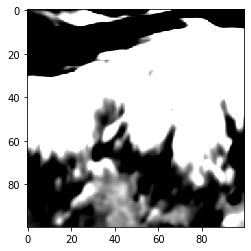

In [ ]:
plt.imshow(data, cmap="gray", vmax=100, vmin=-100)

## 中性線の検出スタート

配列を隣にずらして、隣のピクセルとの差(磁場勾配)を取得

In [ ]:
data_x=np.zeros(data.shape)
data_y=np.zeros(data.shape)
data_x[:,:-1]=data[:,1:]-data[:,:-1]
data_y[:-1,:]=data[1:,:]-data[:-1,:]

x軸とy軸の磁場勾配の可視化

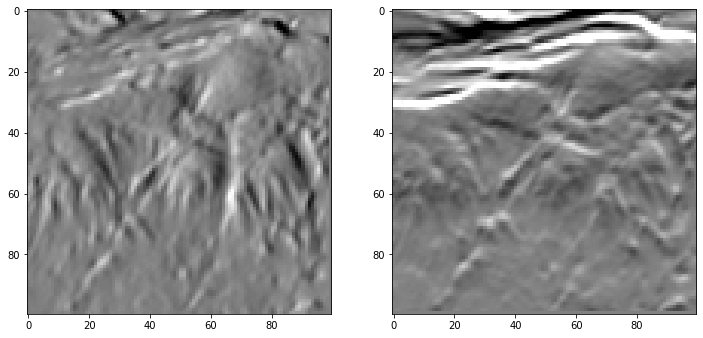

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(data_x, cmap="gray", vmax=300, vmin=-300)
plt.subplot(1,2,2)
plt.imshow(data_y, cmap="gray", vmax=300, vmin=-300)

磁場勾配の絶対値を取得

In [ ]:
data_tmp = np.zeros([100,100,2])
data_tmp[:,:,0] = abs(data_x)
data_tmp[:,:,1] = abs(data_y)

x軸とy軸の勾配で大きいほうを取得

In [ ]:
data_grdmax=np.zeros([100,100])
for ii in np.arange(100):
  for jj in np.arange(100):
    data_grdmax[ii, jj]=data_tmp[ii,jj, np.argmax(data_tmp, axis=2)[ii,jj]]

x軸とy軸を合わせた磁場勾配の可視化

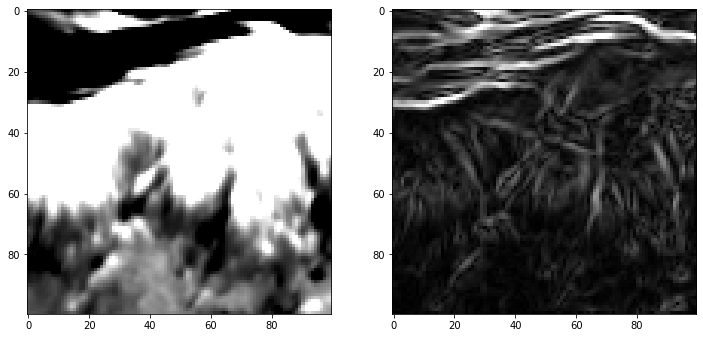

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(data, cmap="gray", vmax=200, vmin=-200)
plt.subplot(1,2,2)
plt.imshow(data_grdmax, cmap="gray", vmax=500, vmin=0)

隣のピクセル同士をかけて、隣同士が黒(負)と白(正)の領域を検出
(マスクの作成)

積が0未満の場合は1(白)にして、0以上の場合は0(黒)にする

In [ ]:
data_sgn_x = np.zeros([100,100])
data_tmp_x = np.zeros([100,100])
data_tmp_x[:,:-1]= data[:,1:] * data[:,:-1]
data_sgn_x[np.where(data_tmp_x < 0)] = 1

data_sgn_y = np.zeros([100,100])
data_tmp_y = np.zeros([100,100])
data_tmp_y[:-1,:]= data[1:,:] * data[:-1,:]
data_sgn_y[np.where(data_tmp_y < 0)] = 1

x軸とy軸のマスクの可視化

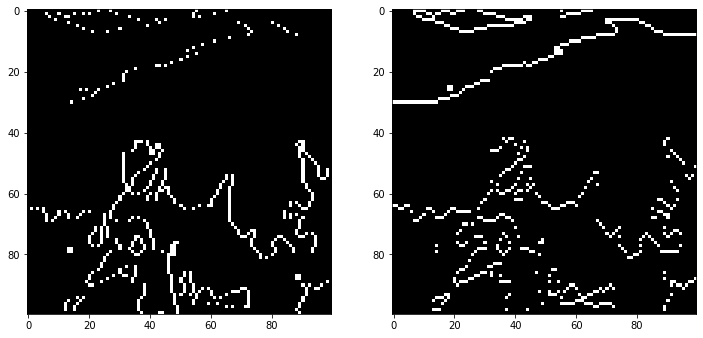

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(data_sgn_x, cmap="gray")
plt.subplot(1,2,2)
plt.imshow(data_sgn_y, cmap="gray")

x軸とy軸でマスクの1となっている方を取得

In [ ]:
data_sgn_tmp = np.zeros([100,100,2])
data_sgn_tmp[:,:,0] = data_sgn_x
data_sgn_tmp[:,:,1] = data_sgn_y
data_sgn=np.zeros([100,100])
for ii in np.arange(100):
  for jj in np.arange(100):
    data_sgn[ii, jj]=data_sgn_tmp[ii,jj, np.argmax(data_tmp, axis=2)[ii,jj]]

x軸とy軸を合わせたマスクマスクの可視化

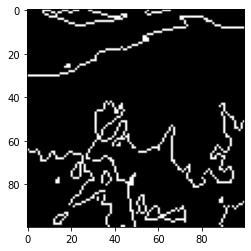

In [ ]:
plt.imshow(data_sgn, cmap="gray")

勾配とマスクをかけて、磁気中性線を検出

In [ ]:
data_grdmax_sgn = data_grdmax * data_sgn

検出された磁気中性線の可視化

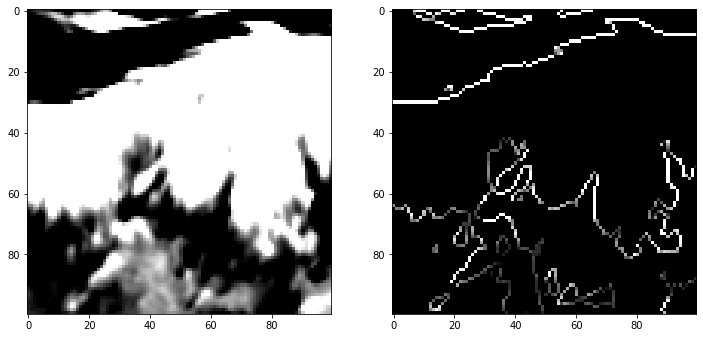

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(data, cmap="gray", vmax=100, vmin=-100)
plt.subplot(1,2,2)
plt.imshow(data_grdmax_sgn, cmap="gray", vmax= 100, vmin=0)

### 磁場勾配の小さなピクセルを削除

磁場勾配の小さなピクセルを削除

In [ ]:
# 勾配閾値の設定
threshold = 10

In [ ]:
ret,binary = cv2.threshold(data_grdmax_sgn,threshold,255,cv2.THRESH_BINARY)
binary = np.uint8(binary)

磁場勾配の小さなピクセルを削除後のマスクを可視化

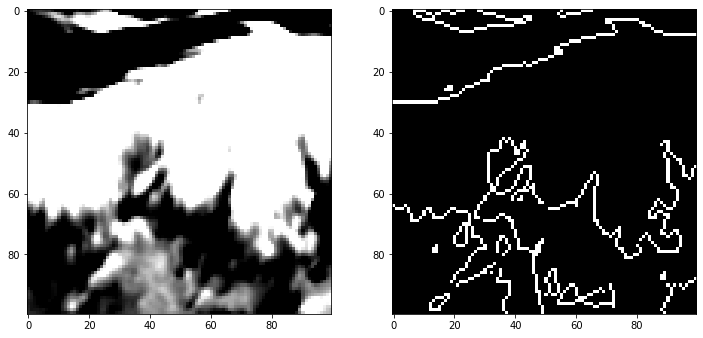

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(data, cmap="gray", vmax=100, vmin=-100)
plt.subplot(1,2,2)
plt.imshow(binary, cmap="gray", vmax= 100, vmin=0)

### 短い中性線を削除

短い中性線を削除

In [ ]:
# 中性線閾値の設定
eliminate_area = 50

In [ ]:
binary_clean, stats = remove_objects(binary, lower_size=eliminate_area, upper_size=None)

短い中性線を削除後のマスクを可視化

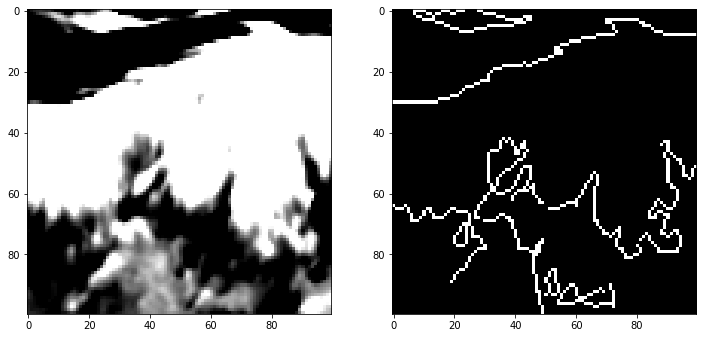

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(data, cmap="gray", vmax=100, vmin=-100)
plt.subplot(1,2,2)
plt.imshow(binary_clean, cmap="gray")
plt.show()

中性線の特徴を出力

In [ ]:
total_area = 0
line_num = 0
long_line = 0
for i, row in enumerate(stats):
  if row[cv2.CC_STAT_AREA] > eliminate_area and i>0:
    print(f"label {i}")
    print(f"* topleft: ({row[cv2.CC_STAT_LEFT]}, {row[cv2.CC_STAT_TOP]})")
    print(f"* size: ({row[cv2.CC_STAT_WIDTH]}, {row[cv2.CC_STAT_HEIGHT]})")
    print(f"* area: {row[cv2.CC_STAT_AREA]}")
    total_area += row[cv2.CC_STAT_AREA]
    line_num += 1
    if long_line < row[cv2.CC_STAT_AREA]:
      long_line = row[cv2.CC_STAT_AREA]

print("\n中性線の本数　：%d"%(line_num))
print("中性線の最大長：%d"%(long_line))
print("中性線の総和　：%d"%(total_area))

label 1
* topleft: (7, 0)
* size: (39, 8)
* area: 74
label 3
* topleft: (0, 3)
* size: (100, 28)
* area: 117
label 5
* topleft: (27, 42)
* size: (23, 27)
* area: 98
label 6
* topleft: (81, 43)
* size: (19, 37)
* area: 90
label 7
* topleft: (51, 53)
* size: (31, 29)
* area: 65
label 9
* topleft: (0, 64)
* size: (31, 26)
* area: 76
label 10
* topleft: (30, 67)
* size: (20, 33)
* area: 56
label 15
* topleft: (50, 85)
* size: (23, 13)
* area: 64

中性線の本数　：8
中性線の最大長：117
中性線の総和　：640


## 元画像と中性線検出マスクを保存

変数を宣言

In [ ]:
plt_save = False # 画像保存を指定
dir = "/content/drive/MyDrive/Colab Notebooks/lab/univ_master/" # 保存ディレクトリを指定

元画像と中性線検出マスクを保存

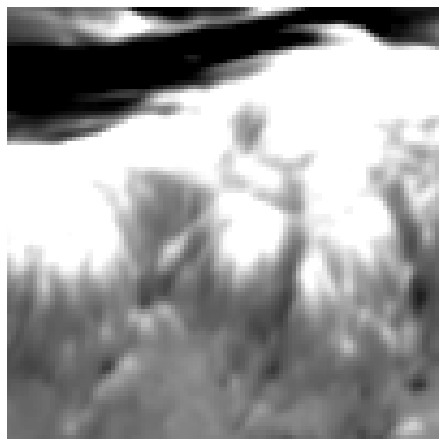

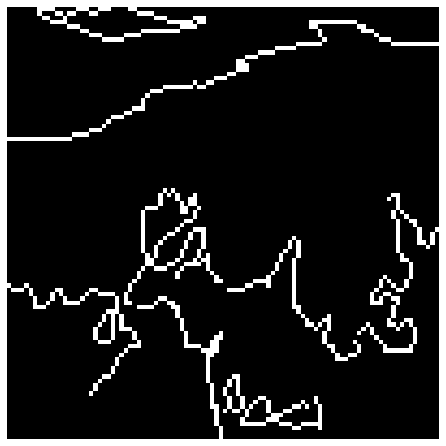

In [ ]:
# 画像を保存
plt.figure(figsize=(6,6))
plt.imshow(data, cmap="gray", vmax=600, vmin=-600)
plt.axis("off")
#plt.gca().invert_yaxis()
plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
if plt_save:
  plt.savefig(dir + "Original_image.png")
plt.show()

plt.figure(figsize=(6,6))
plt.imshow(binary_clean, cmap="gray")
plt.axis("off")
#plt.gca().invert_yaxis()
plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
if plt_save:
  plt.savefig(dir + "Mask_image.png")
plt.show()

## 最終的な磁気中性線画像を作成

変数を宣言

In [ ]:
plt_neutral_save = False # 画像保存を指定

磁気中性線画像を可視化

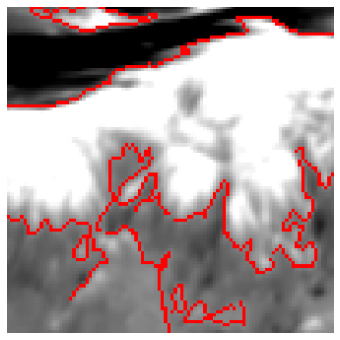

In [ ]:
# マスク対象画像読み込み
img = cv2.imread(dir + "Original_image.png",cv2.IMREAD_COLOR)

# マスク画像読み込み
imgMask = cv2.imread(dir + "Mask_image.png",cv2.IMREAD_GRAYSCALE)

# マスク画像合成
img[imgMask>0] = [255, 0, 0]

# 画像を表示
plt.figure(figsize=(6,6))
plt.imshow(img)
plt.axis("off")
if plt_neutral_save:
  plt.savefig(dir + "Neutral_image.png")
plt.show()